In [1]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

In [2]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

# Create Graph using Bipartite Projection on Arxiv Dataset

In [3]:
data = r'C:\Users\groov\PythonCode\100daysofnetworks\data\arxiv_network_science_data.csv'

df = pd.read_csv(data)

df = pd.read_csv(data)
df['authors'] = df['authors'].apply(literal_eval)

df = df[['authors', 'title']]
df = df.explode('authors')
df.reset_index(drop=True, inplace=True)

# fix the & so that scikit-network stops crashing
df['authors'] = df['authors'].str.replace('&', 'and')
df['title'] = df['title'].str.replace('&', 'and')

df.head()

,authors,title
0,Dustin Nguyen,Neural ODEs as a discovery tool to characteriz...
1,Yuan-Sen Ting,Neural ODEs as a discovery tool to characteriz...
2,Todd A. Thompson,Neural ODEs as a discovery tool to characteriz...
3,Sebastian Lopez,Neural ODEs as a discovery tool to characteriz...
4,Laura A. Lopez,Neural ODEs as a discovery tool to characteriz...


In [4]:
from networkx.algorithms import bipartite

B = nx.from_pandas_edgelist(df, source='authors', target='title')
G = bipartite.projected_graph(B, df['authors'])

G = nx.k_core(G, 2) # no isolates or two-node groups

In [5]:
print(nx.info(G))

Graph with 59260 nodes and 302588 edges


# Community Detection + Community Analysis

There's two parts to what I am attempting today.
- I need to use community detection to identify communities in the network.
- I can then use network science and data science to identify interesting communities

By interesting, I mean not stars. I am looking for complex ecosystems. So, I will identify communities, then attempt to detect more complex ecosystems by using triangles and density.

## Community Detection

In [6]:
import community as community_louvain

partition = community_louvain.best_partition(G, resolution=0.01, random_state=1337) # 10 was good for this network

In [7]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

# remove junk; identify relevant communities

community_df['community'].value_counts()[0:20]

51      97
27      95
657     90
432     88
454     88
242     87
630     84
509     83
5       81
258     80
459     78
426     78
301     77
1653    76
313     74
400     73
898     73
184     73
1850    73
408     72
Name: community, dtype: int64

In [8]:
community_node_counts = community_df['community'].value_counts()

community_size_df = pd.DataFrame(community_node_counts).reset_index()
community_size_df.columns = ['community', 'node_count']

# just to speed up this experiment
community_size_df = community_size_df[community_size_df['node_count'] > 10]

community_size_df.head()

,community,node_count
0,51,97
1,27,95
2,657,90
3,432,88
4,454,88


In [9]:
community_size_df.shape

(1296, 2)

## Capture Community Context

In [10]:
community_df.head()

,node,community
0,Dustin Nguyen,0
1,Yuan-Sen Ting,0
2,Todd A. Thompson,0
3,Sebastian Lopez,0
4,Laura A. Lopez,0


In [11]:
community_size_df.head(1)

,community,node_count
0,51,97


In [12]:
def get_community_nodes(community_df, community):

    return sorted(community_df[community_df['community']==community]['node'].values)

In [13]:
def get_community_context(community_size_df, community_df, G):

    G = G.copy()

    communities = {}

    for row in community_size_df.iterrows():

        data = row[1]
        community = data['community']
        node_count = data['node_count']
        
        nodes = get_community_nodes(community_df, community)
        G_sub = G.subgraph(nodes)

        # starting with density today; will add on more context later
        density = nx.density(G_sub)
        
        communities[community] = {}

        communities[community]['G'] = G_sub
        communities[community]['density'] = density
        communities[community]['node_count'] = len(G_sub.nodes)
        
    return communities

In [14]:
community_context_dict = get_community_context(community_size_df, community_df, G)

In [15]:
community_context_df = pd.DataFrame(community_context_dict).T.reset_index()
community_context_df.columns = ['community', 'G', 'density', 'node_count']

community_context_df.head()

,community,G,density,node_count
0,51,"(Narisa Zhao, Nguyen Cong Luong, Amir Leshem, ...",0.075172,97
1,27,"(Saray Shai, Elvira Maria Restrepo, Mason A. P...",0.054199,95
2,657,"(Wenbo Du, Bnaya Gross, Xingshu Chen, Yuanshen...",0.061423,90
3,432,"(Benjamin Machta, Pawel Sobkowicz, Kishan Govi...",0.062173,88
4,454,"(Alejandro Ribeiro, Jean M. Vettel, Ankit N. K...",0.073406,88


<AxesSubplot:ylabel='Frequency'>

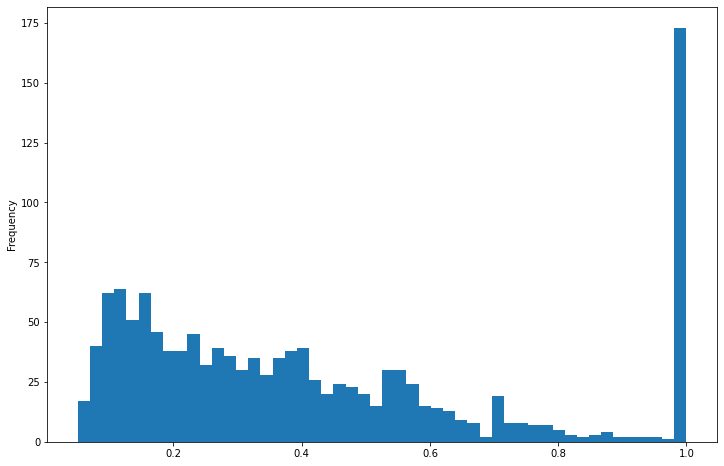

In [16]:
community_context_df['density'].plot.hist(bins=50, figsize=(12,8))

#### Investigate Communities

In [17]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

In [18]:
def show_author_papers(df, G):
    
    G = G.copy()
    
    check_nodes = G.nodes

    return sorted(df[df['authors'].isin(check_nodes)]['title'].unique())

In [19]:
def fetch_communities(community_context_df, min_density, max_density, max_nodes=None):
    
    if max_nodes==None:
        community_context_df['node_count'].sum()
    
    community_context_df = community_context_df.copy()

    mask = (community_context_df['density']>min_density) \
        & (community_context_df['density']<max_density)  \
        & (community_context_df['node_count']<max_nodes)
    
    community_context_df = community_context_df[mask].copy()
    community_context_df = community_context_df.sample(10) # grabbing ten to see the ranges

    community_context_df.sort_values('density', inplace=True)
    communities = community_context_df['community'].values[0:10]
    
    return communities

In [20]:
def draw_community(G_check):

    print('Density: {}'.format(nx.density(G_check)))
    print('Node Count: {}'.format(len(G_check.nodes)))
    return draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

In [42]:
min_density = 0.1
max_density = 0.3
max_nodes = 100

communities = fetch_communities(community_context_df, min_density=min_density, max_density=max_density, max_nodes=max_nodes)
communities

array([1865,  168, 1090,  298, 2193,  978, 1085,  507, 3927, 3333],
      dtype=int64)

Density: 0.10823311748381129
Node Count: 47


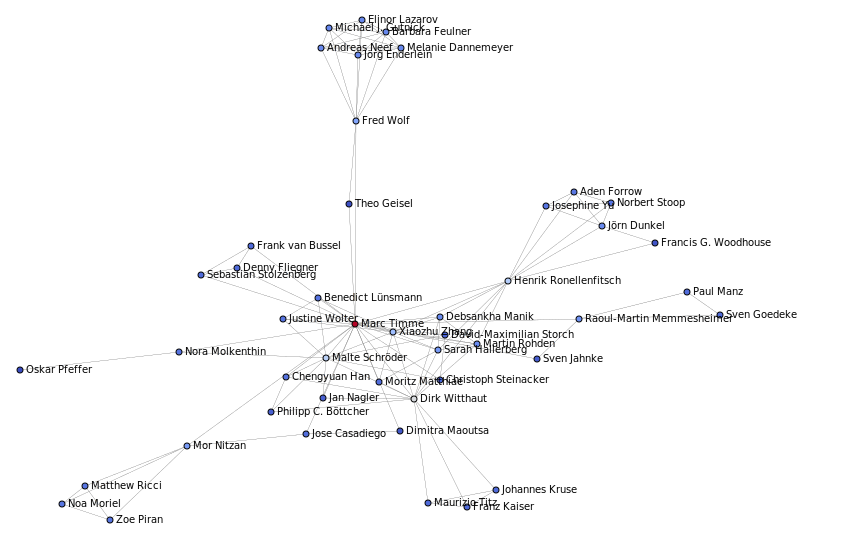

In [43]:
G_check = community_context_dict[communities[0]]['G']
draw_community(G_check)

In [44]:
show_author_papers(df, G_check)

['A Dual Method for Computing Power Transfer Distribution Factors',
 'Adhesion-induced Discontinuous Transitions and Classifying Social Networks',
 'An axon initial segment is required for temporal precision in action potential encoding by neuronal populations',
 'Antagonistic Phenomena in Network Dynamics',
 'Autonomous actuation of zero modes in mechanical networks far from equilibrium',
 'Collective Relaxation Dynamics of Small-World Networks',
 'Competitive percolation strategies for network recovery',
 'Counting Complex Disordered States by Efficient Pattern Matching: Chromatic Polynomials and Potts Partition Functions',
 'Demand-driven design of bicycle infrastructure networks for improved urban bikeability',
 'Designing Complex Networks',
 'Does dynamics reflect topology in directed networks?',
 'Dynamics and computation in mixed networks containing neurons that accelerate towards spiking',
 'Fluctuation-induced Distributed Resonances in Oscillatory Networks',
 'Formation of tra

Density: 0.11153846153846154
Node Count: 40


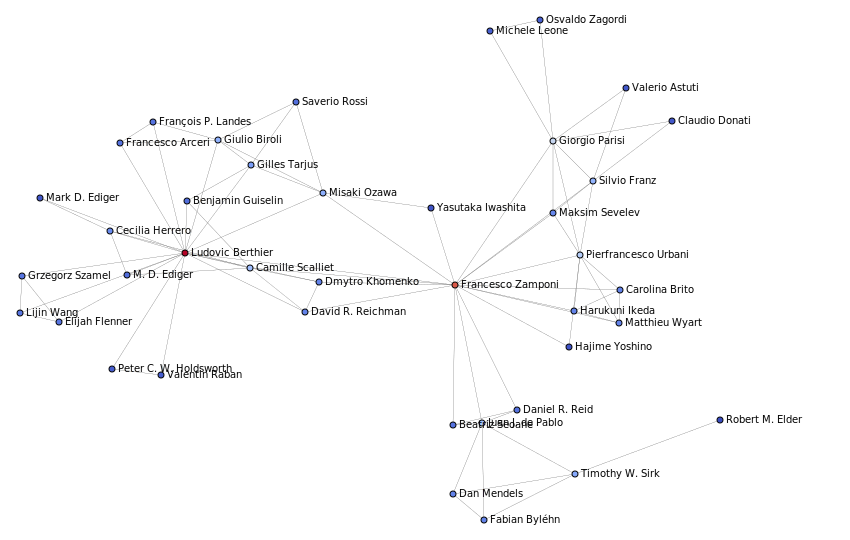

In [65]:
G_check = community_context_dict[communities[1]]['G']
draw_community(G_check)

In [46]:
show_author_papers(df, G_check)

['A stability-reversibility map unifies elasticity, plasticity, yielding and jamming in hard sphere glasses',
 'A unified framework for non-Brownian suspension flows and soft amorphous solids',
 'Attractor Neural Networks',
 'Computer simulations of the glass transition and glassy materials',
 'Creating bulk ultrastable glasses by random particle bonding',
 'Depletion of two-level systems in ultrastable computer-generated glasses',
 'Direct numerical analysis of dynamic facilitation in glass-forming liquids',
 'Edge Mode Amplification in Disordered Elastic Networks',
 'Effects of compression on the vibrational modes of marginally jammed solids',
 'Emergence of a random field at the yielding transition of a mean-field Elasto-Plastic model',
 'Emergence of rigidity at the structural glass transition: a first principle computation',
 'Excess wings and asymmetric relaxation spectra in a facilitated trap model',
 'Far-from-equilibrium criticality in the Random Field Ising Model with Eshelby

Density: 0.11932773109243698
Node Count: 35


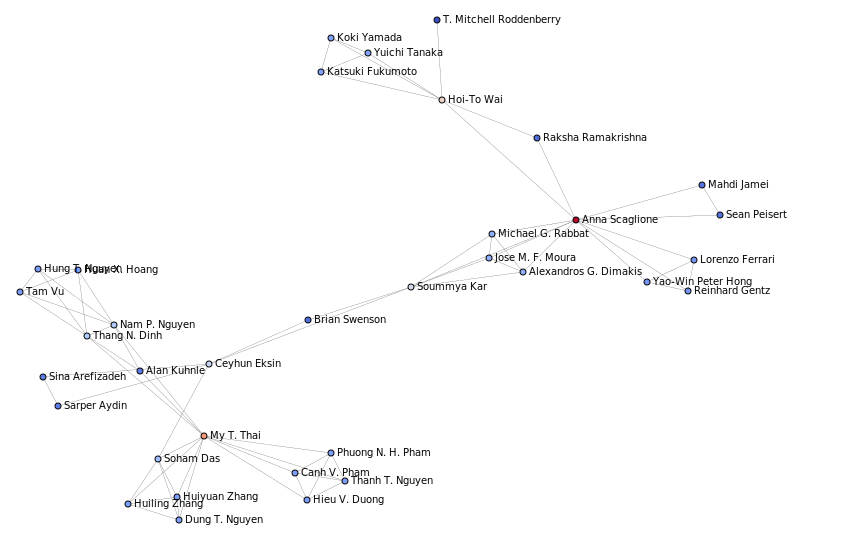

In [47]:
G_check = community_context_dict[communities[2]]['G']
draw_community(G_check)

In [48]:
show_author_papers(df, G_check)

['A User Guide to Low-Pass Graph Signal Processing and its Applications',
 'Average submodularity of maximizing anticoordination in network games',
 'Clustering of Time-Varying Graphs Based on Temporal Label Smoothness',
 'Control of learning in anti-coordination network games',
 'Convergence Results on Pulse Coupled Oscillator Protocols in Locally Connected Networks',
 'Cost-aware Targeted Viral Marketing: Approximation with Less Samples',
 'Decentralized Fictitious Play Converges Near a Nash Equilibrium in Near-Potential Games',
 'Distributed Inertial Best-Response Dynamics',
 'Exact Blind Community Detection from Signals on Multiple Graphs',
 'Finding Community Structure with Performance Guarantees in Complex Networks',
 'Gossip Algorithms for Distributed Signal Processing',
 'Groups Influence with Minimum Cost in Social Networks',
 'Information Preferences of Individual Agents in Linear-Quadratic-Gaussian Network Games',
 'Least Cost Influence Maximization Across Multiple Social Ne

Density: 0.1737891737891738
Node Count: 27


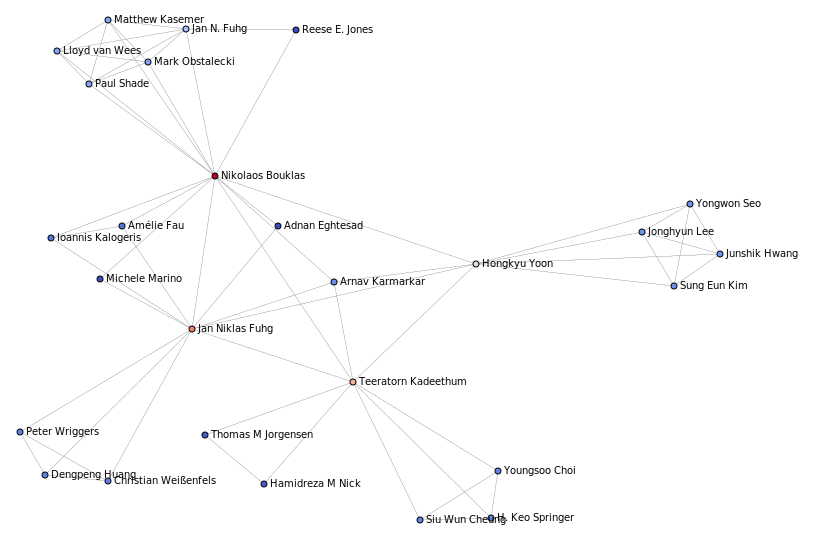

In [49]:
G_check = community_context_dict[communities[3]]['G']
draw_community(G_check)

In [50]:
show_author_papers(df, G_check)

['A machine learning based plasticity model using proper orthogonal decomposition',
 'Connectivity-informed Drainage Network Generation using Deep Convolution Generative Adversarial Networks',
 'Data-scarce surrogate modeling of shock-induced pore collapse process',
 'Deep Convolutional Ritz Method: Parametric PDE surrogates without labeled data',
 'Extreme sparsification of physics-augmented neural networks for interpretable model discovery in mechanics',
 'Interval and fuzzy physics-informed neural networks for uncertain fields',
 'Learning hyperelastic anisotropy from data via a tensor basis neural network',
 'Local approximate Gaussian process regression for data-driven constitutive laws: Development and comparison with neural networks',
 'Machine-learning convex and texture-dependent macroscopic yield from crystal plasticity simulations',
 'NN-EVP: A physics informed neural network-based elasto-viscoplastic framework for predictions of grain size-aware flow response under large de

Density: 0.1906906906906907
Node Count: 37


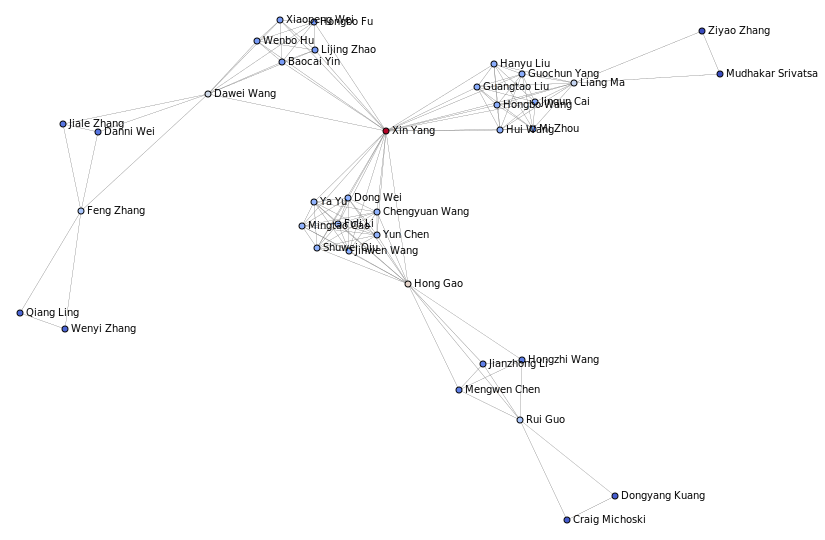

In [51]:
G_check = community_context_dict[communities[4]]['G']
draw_community(G_check)

In [52]:
show_author_papers(df, G_check)

['A Monotonicity Constrained Attention Module for Emotion Classification with Limited EEG Data',
 'Competition Between Wireless Service Providers: Pricing, Equilibrium and Efficiency',
 'DEMC: A Deep Dual-Encoder Network for Denoising Monte Carlo Rendering',
 'Design and Synthesis of Clathrate LaB8 with Superconductivity',
 'Emergence of Symmetry in Complex Networks',
 'Forgetting Prevention for Cross-regional Fraud Detection with Heterogeneous Trade Graph',
 'KAM -- a Kernel Attention Module for Emotion Classification with EEG Data',
 'Network Quotients: Structural Skeletons of Complex Systems',
 'Neural Network Tomography',
 'Non-cooperative Game For Capacity Offload',
 'Parallelization in Extracting Fresh Information from Online Social Network',
 'Query Answering via Decentralized Search',
 'Robustness of Complex Networks against Attacks Guided by Damage',
 'Structural phase transition of two-dimensional monolayer SnTe from artificial neural network',
 'Symmetry based Structure Entr

Density: 0.2044334975369458
Node Count: 29


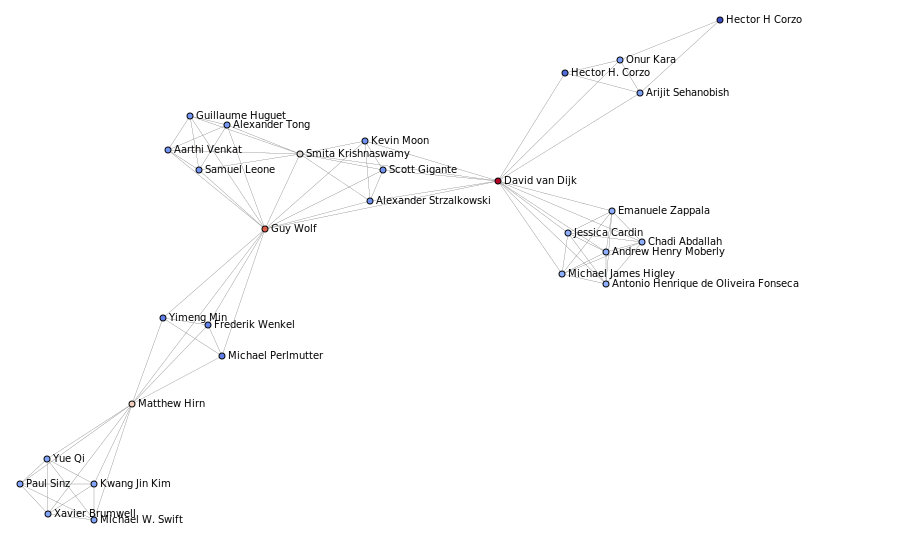

In [53]:
G_check = community_context_dict[communities[5]]['G']
draw_community(G_check)

In [54]:
show_author_papers(df, G_check)

['Fine-tuning Vision Transformers for the Prediction of State Variables in Ising Models',
 'Graph Fourier MMD for Signals on Graphs',
 'Learning Full Configuration Interaction Electron Correlations with Deep Learning',
 'Learning Potentials of Quantum Systems using Deep Neural Networks',
 'Modeling Global Dynamics from Local Snapshots with Deep Generative Neural Networks',
 'Neural Integro-Differential Equations',
 'Overcoming Oversmoothness in Graph Convolutional Networks via Hybrid Scattering Networks',
 'Wavelet Scattering Networks for Atomistic Systems with Extrapolation of Material Properties']

Density: 0.20923076923076922
Node Count: 26


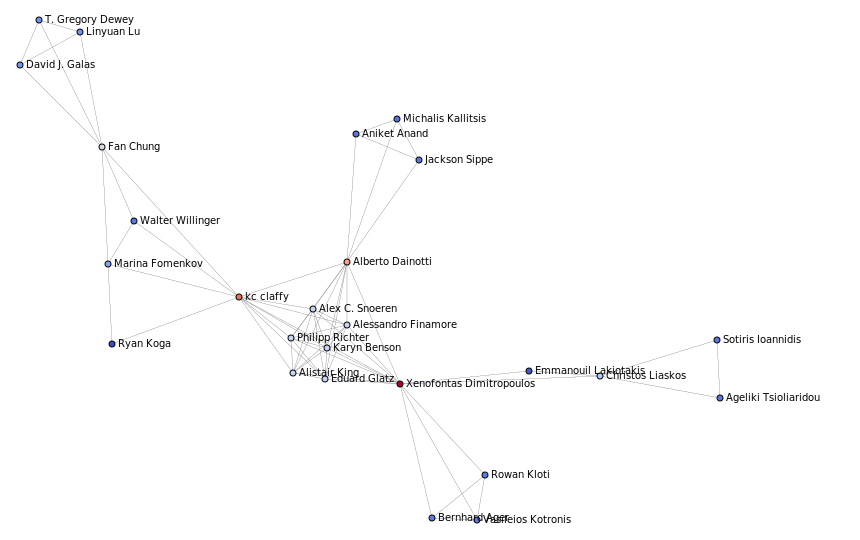

In [55]:
G_check = community_context_dict[communities[6]]['G']
draw_community(G_check)

In [56]:
show_author_papers(df, G_check)

['Aggressive Internet-Wide Scanners: Network Impact and Longitudinal Characterization',
 'Coarse Graining for Synchronization in Directed Networks',
 'Duplication Models for Biological Networks',
 'Evolution of the Internet AS-Level Ecosystem',
 'Improving Networked Music Performance Systems Using Application-Network Collaboration',
 'Link Prediction in Complex Networks: A Survey',
 'Lost in Space: Improving Inference of IPv4 Address Space Utilization',
 'Navigability of Complex Networks',
 'Policy-Compliant Path Diversity and Bisection Bandwidth',
 'Predicting Missing Links via Local Information',
 'The Socket Store: An App Model for the Application-Network Interaction',
 'The Workshop on Internet Topology (WIT) Report']

Density: 0.2276923076923077
Node Count: 26


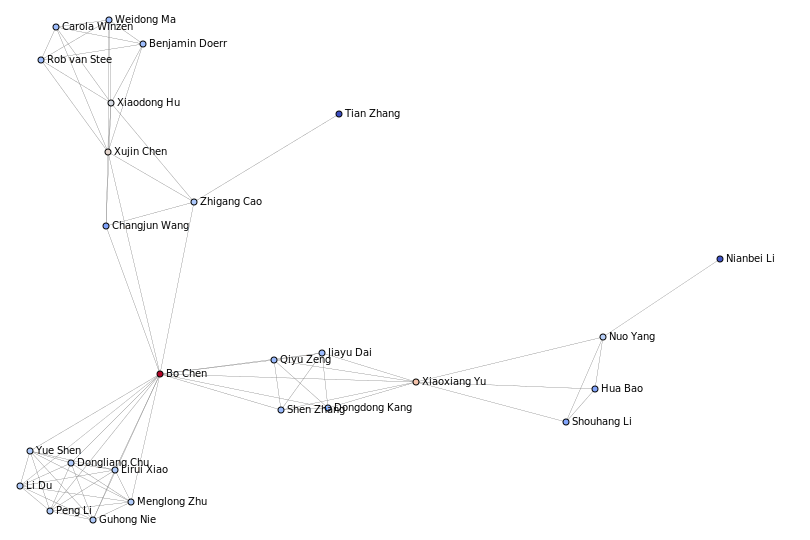

In [57]:
G_check = community_context_dict[communities[7]]['G']
draw_community(G_check)

In [58]:
show_author_papers(df, G_check)

['A Network Game of Dynamic Traffic',
 'Binary Neural Networks as a general-propose compute paradigm for on-device computer vision',
 'Coalitional Game Theoretic Approach for Cooperative Transmission in Vehicular Networks',
 'Data offloading in mobile edge computing: A coalitional game based pricing approach',
 'East Asian VLBI Network Observations of Active Galactic Nuclei Jets: Imaging with KaVA+Tianma+Nanshan',
 'Full-scale ab initio simulations of laser-driven atomistic dynamics',
 'Fully Hyperbolic Neural Networks',
 'Hierarchic Power Allocation for Spectrum Sharing in OFDM-Based Cognitive Radio Networks',
 'High thermal conductivity of bulk epoxy resin by bottom-up parallel-linking and strain: a molecular dynamics study',
 'How to Schedule the Marketing of Products with Negative Externalities',
 'Pricing in Social Networks with Negative Externalities',
 'Providing Probabilistic Robustness Guarantee for Crowdsensing',
 'The Price of Anarchy for Selfish Ring Routing is Two',
 'Ther

Density: 0.22794117647058823
Node Count: 17


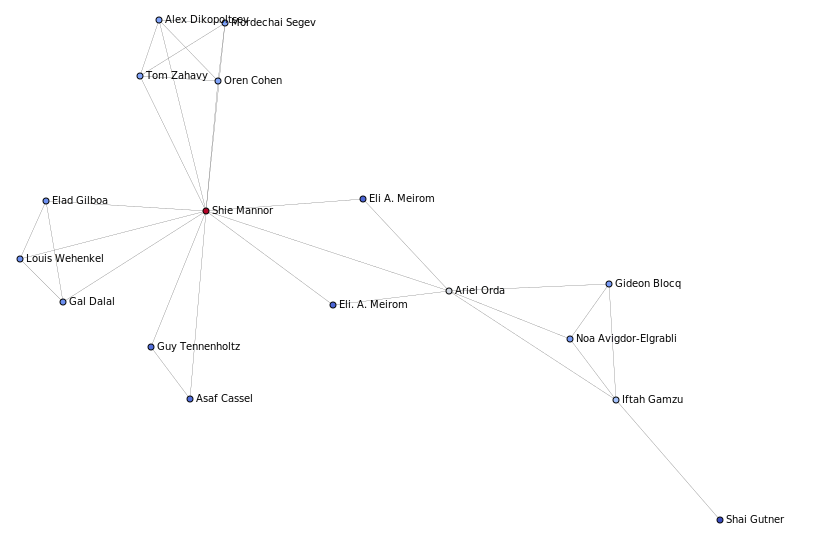

In [59]:
G_check = community_context_dict[communities[8]]['G']
draw_community(G_check)

In [60]:
show_author_papers(df, G_check)

['A Sublogarithmic Approximation for Highway and Tollbooth Pricing',
 'Chance-Constrained Outage Scheduling using a Machine Learning Proxy',
 'Coalitions in Routing Games: A Worst-Case Perspective',
 'Deep Learning Reconstruction of Ultra-Short Pulses',
 'Efficiency Loss in a Network Resource Allocation Game: The Case of Elastic Supply',
 'Formation Games of Reliable Networks',
 'How Good is Bargained Routing?',
 'Network Formation Games with Heterogeneous Players and the Internet Structure',
 'Offline and Online Models of Budget Allocation for Maximizing Influence Spread',
 'Strategic Formation of Heterogeneous Networks',
 'The Pendulum Arrangement: Maximizing the Escape Time of Heterogeneous Random Walks',
 'Truthful Unsplittable Flow for Large Capacity Networks']

Density: 0.2833333333333333
Node Count: 16


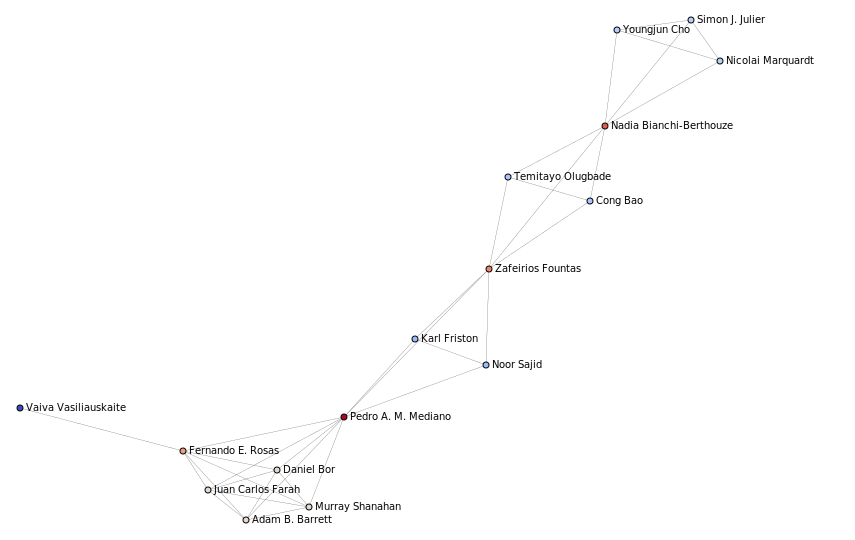

In [66]:
G_check = community_context_dict[communities[9]]['G']
draw_community(G_check)

In [62]:
show_author_papers(df, G_check)

['Deep Thermal Imaging: Proximate Material Type Recognition in the Wild through Deep Learning of Spatial Surface Temperature Patterns',
 'Deep active inference agents using Monte-Carlo methods',
 'Integrated information as a common signature of dynamical and information-processing complexity',
 'Making Communities Show Respect for Order',
 'Multimodal Data Fusion based on the Global Workspace Theory',
 'Understanding complexity via network theory: a gentle introduction']

In [63]:
# seems to be that...
# more dense: collaborative papers but fewer
# less dense: more single author papers causing network sparcity

# 'Online-updated High-order Collaborative Networks for Single Image Deraining',
# found a paper about collaborative papers while studying author collaboration :D